# Spapros Evaluation: Compare a selection of probesets with a list of markers

This tutorial shows how to apply spapros for the evaluation of a probeset.

The used data set consists of ...

It is available ...

## Import packages and data

To run the notebook locally, create a conda environment using this [environment.yaml](TODO link):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [1]:
import spapros
from spapros.evaluation import ProbesetEvaluator
from IPython.display import clear_output
import scanpy as sc
import pandas as pd
import os
import yaml

In [2]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.1 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.2
spapros==0.1.0


In [3]:
# Load the dataset
adata = sc.read_h5ad("../data/small_data_raw_counts.h5ad")

First, let's examine the data with a UMAP representation.

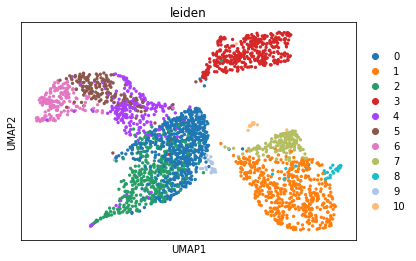

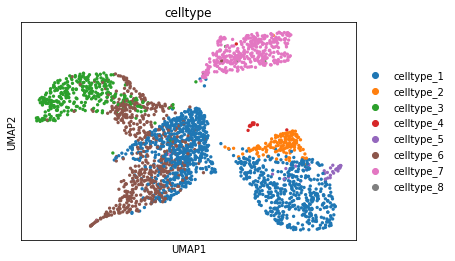

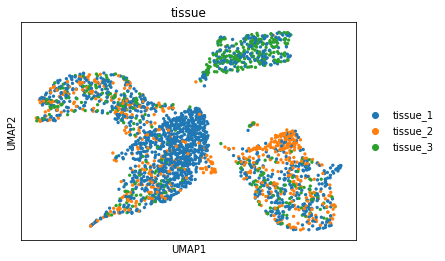

In [4]:
adata_tmp = adata.copy()
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp,color='leiden')
sc.pl.umap(adata_tmp,color='celltype')
sc.pl.umap(adata_tmp,color='tissue')

In [5]:
# Load the selection genesets
selection = pd.read_csv("../results/selections_genesets_1.csv", index_col="index")
selection

,genesets_1_0,genesets_1_1,genesets_1_2,genesets_1_3,genesets_1_4,genesets_1_5,genesets_1_6,genesets_1_7,genesets_1_8,genesets_1_9,...,genesets_1_118,genesets_1_119,genesets_1_120,genesets_1_121,genesets_1_122,genesets_1_123,genesets_1_124,genesets_1_125,genesets_1_126,genesets_1_127
index,,,,,,,,,,,,,,,,,,,,,
ISG15,True,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
TNFRSF4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CPSF3L,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
ATAD3C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RP11-345P4.10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AIRE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SLC19A1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
COL6A2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [6]:
# Note:
# These probe sets were created with:

    spapros select data/small_data_raw_counts.h5ad

In [7]:
# Show the sizes of the genesets
print("size\tnumber of sets")
selection.sum().value_counts()

size	number of sets


20     64
100    64
dtype: int64

In [8]:
# Define and check output directory
results_dir = "tutorial_probeset_evaluation"
if os.path.isdir(results_dir):
    print(f"You already have a directory called {results_dir}. "
          f"Please clear it. "
          f"Otherwise, it might be overwritten by this notebook or it will disturb the summaries and plots.")

## Evaluate the selection: Minimal Example

Run the probe set evaluation pipeline from command line as follows:

    spapros evaluation [OPTIONS] ADATA MARKER_FILE [PROBESET_IDS] [PARAMETERS] [OUTPUT]

Or do it in python using the ProbesetEvaluator class:

In [9]:
evaluator = ProbesetEvaluator(adata, results_dir=results_dir)
# Note:
# In adata.obs['celltype'], cell types need to be stored.
# Otherwise, you need to specify celltype_key to the adata.obs where you stored them.

## Evaluate a single probeset:

In [10]:
# Let's start with the first selection (column 0).
set_id = selection.columns[0]
print(f"We use the column name as set id: {set_id}")

# Get the genes of the probe set that you want to evaluate.
genes = selection.index[selection[set_id]]
print("The gene set to evaluate: ")
print(genes.to_list())

We use the column name as set id: genesets_1_0
The gene set to evaluate: 
['ISG15', 'IFI6', 'S100A11', 'S100A9', 'S100A8', 'FCER1G', 'FCGR3A', 'GNLY', 'GPX1', 'IL7R', 'CD74', 'LTB', 'HLA-DPA1', 'HLA-DPB1', 'SAT1', 'LYZ', 'IL32', 'CCL5', 'NKG7', 'LGALS1']


In [11]:
# Make sure that all of the genes are in the adata.var_names
all(genes.isin(adata.var_names))
# Note:
# If False, your genes list is not compatible with your anndata.
# Maybe you are using gene ids instead of gene names.

True

In [12]:
# Start the evaluation
evaluator.evaluate_probeset(genes=genes.tolist(), set_id=set_id)

The following cell types are not included in forest classifications since they have fewer 
than 40 cells: ['celltype_5', 'celltype_4', 'celltype_8']

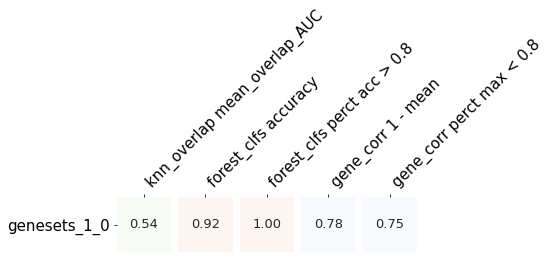

In [13]:
# Look at the results stored in evaluator.summary_results
evaluator.plot_summary()

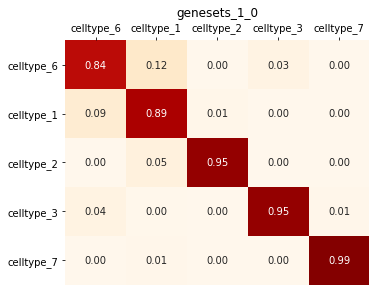

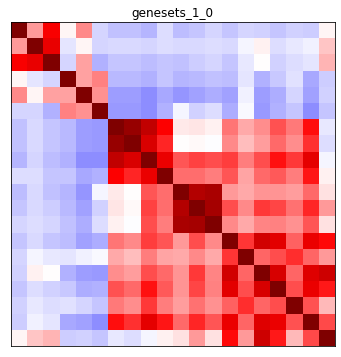

In [14]:
# Visualize the results
evaluator.plot_evaluations()

In [15]:
# Save the results
#TODO

# attention:
# the default behaviour is to save the results in ./probeset_evaluation
# the output directory can be changed by setting the parameter results_dir
# the final result file is saved as results_dir/{metric}/{reference_name}_{set_id}.csv
# if a result file is already existing, the calculation is skipped
# result files are not deleted automatically --> need to be deleted manually if necessary
# all existing result files in the specified result_dir are reloaded into the evaluator for plotting

# If you do not want to store the results, use `results_dir=None`

## Customize the metric parameters

The argument `metrics_param` can provide a dictionary of dictionarys containing parameters for the calculation of each metric.

Example:

In [16]:
param_yaml = "../data/parameters.yml"
with open(param_yaml, "r") as file:
    custom_params = yaml.load(file, Loader=yaml.FullLoader)
custom_params

{'data': {'name': 'small_data',
  'process_adata': ['norm', 'log1p'],
  'celltype_key': 'celltype'},
 'metrics': {'cluster_similarity': {'ns': [5, 21],
   'AUC_borders': [[7, 14], [15, 20]]},
  'knn_overlap': {'ks': [5, 10, 15, 20, 25, 30]},
  'forest_clfs': {'ct_key': 'celltype', 'threshold': 0.8},
  'marker_corr': {'per_celltype': True,
   'per_marker': True,
   'per_celltype_min_mean': None,
   'per_marker_min_mean': 0.025},
  'gene_corr': {'threshold': 0.8}}}

The following cell types are not included in forest classifications since they have fewer 
than 40 cells: ['celltype_5', 'celltype_4', 'celltype_8']

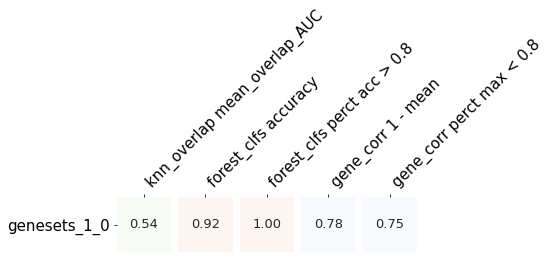

In [17]:
custom_evaluator = ProbesetEvaluator(adata,
                                     metrics_params=custom_params,
                                     results_dir="tutorial_probeset_evaluation_custom")

# Note:
# This second ProbesetEvaluator instance is created with another results_dir
# because having the same adata and the same genesets (and names for both), the new result files would have the same
# names as the old ones.
# Thus, the new calculations would be skipped.
# If you wish to compare the old results with the new results, the best alternative is to keep the old results_dir
# and change the set_id for all new probeset evaluations.

custom_evaluator.evaluate_probeset(genes=genes.tolist(), set_id=set_id)

custom_evaluator.plot_summary()


## Evaluate multiple probesets sequentially

In [18]:
for set_id in selection.columns:
    print(set_id)
    gene_list = selection.index[selection[set_id]].to_list()
    custom_evaluator.evaluate_probeset(gene_list, set_id=set_id)

    clear_output(wait=True)

# Note:
# The set_id has to be set differently for each iteration.
# Otherwise, the results will not be calculated.

genesets_1_127


The following cell types are not included in forest classifications since they have fewer 
than 40 cells: ['celltype_5', 'celltype_4', 'celltype_8']

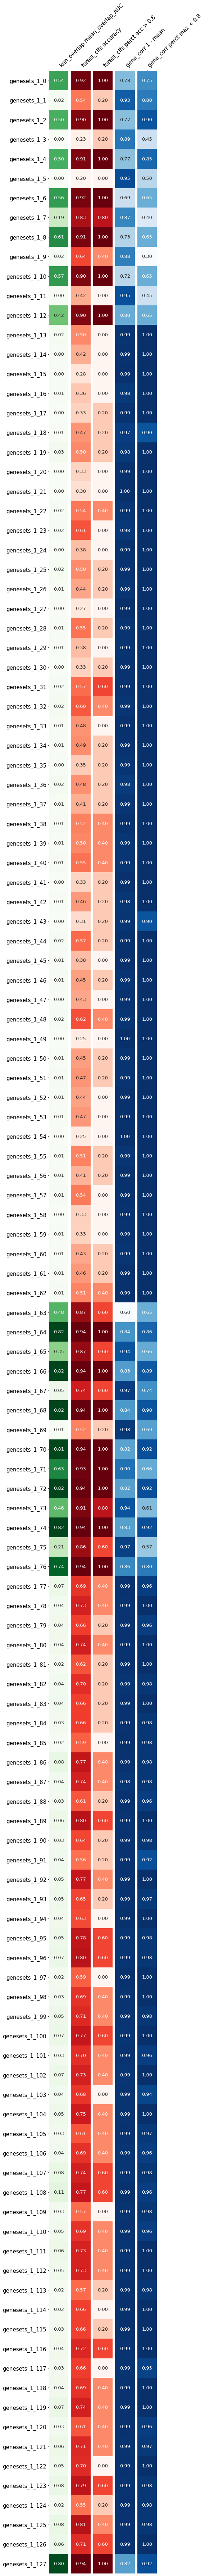

In [19]:
custom_evaluator.plot_summary()

This shows that the last probe set is the best one.
Let's look at a UMAP of this probe set:

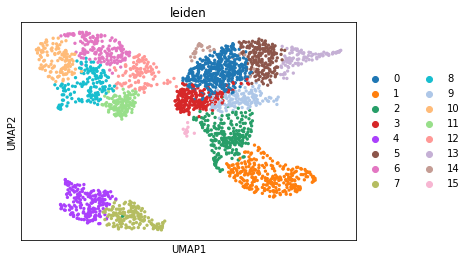

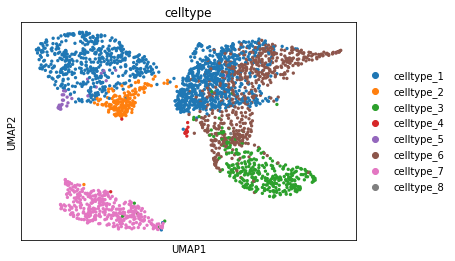

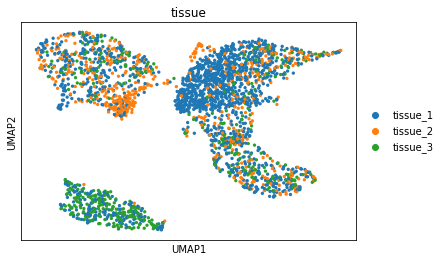

In [20]:
best_set_id = "genesets_1_127"
adata_tmp = adata[:, selection[best_set_id]].copy()
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.leiden(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp,color='leiden')
sc.pl.umap(adata_tmp,color='celltype')
sc.pl.umap(adata_tmp,color='tissue')

## Additional metrics

By default, `metric_scheme="quick"`, which means that only the faster metrics are calculated, which are:
>- knn
>- forest classification
>- marker correlation (if marker list given, eg. `marker_list="../data/small_data_marker_list.csv"`)
>- gene correlation

Through setting scheme="full", additionally the following metric is calculated:
>- nmi

Alternatively, you can `scheme="custom"` and `metrics=custom_list` where `custom_list` is a list of the metrics of interest.

So now let's compare all metrics for our best probe set.

/big/st/strasserl/spapros/spapros/evaluation/metrics.py:850: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  summaries = cor_df[[col for col in cor_df.columns if (col != "mean")]].mean(axis=0)


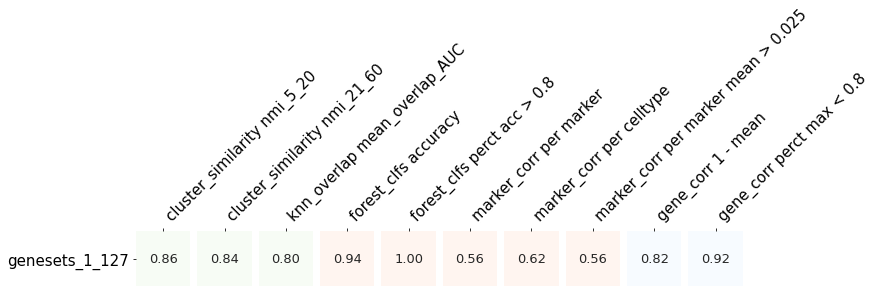

In [21]:
best_genes = selection.index[selection[best_set_id]]

custom_evaluator = ProbesetEvaluator(adata,
                                     marker_list="../data/small_data_marker_list.csv",
                                     scheme="full",
                                     metrics_params=custom_params,
                                     results_dir="tutorial_probeset_evaluation_custom")
# Note:
# We use the same result_dir again, because we do not alter anything,
# just adding some metrics.

custom_evaluator.evaluate_probeset(genes=best_genes.tolist(), set_id=best_set_id)

custom_evaluator.plot_summary(set_ids=[best_set_id])



In [22]:
# further tutorial topics:
# evaluate multiple probesets parallelised
# reference evaluations !!! select_reference_probesets not found in spapros.selection???
# analyze the command line pipeline output files: evaluator.pipeline_summary_statistics()
# change metrics (scheme) and metric params, add marker_corr (marker_list = "../data/small_data_marker_list.csv")

#TODO
# add links where to find the further tutorials like this
# ::: {.seealso} Tutorial 1 TODO etc :::



